In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace

from scipy.linalg import sqrtm,inv

In [2]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

In [3]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*pi/180

lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

img_ft = (random.randn(n,n)+1j*np.random.randn(n,n))/np.sqrt(2)*1./(1+lmaggrid)
img = np.real(fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

mask = random.randn(n,n)>-.8

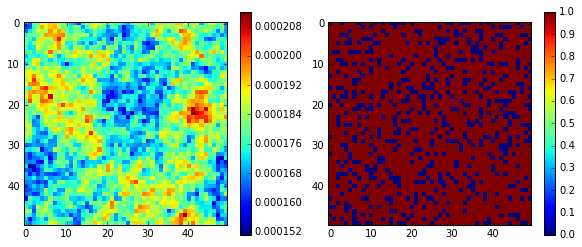

In [4]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img,interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.imshow(mask,interpolation='nearest')
plt.colorbar()

In [5]:
lmin,lmax = 200,5000
nbins = 6
img_meas = img*mask

lbins,pspec,bin_counts = img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False)
lbins,pspec_m,bin_counts = img2PS(img_meas,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False)

5091.16882454
5091.16882454


In [6]:
# begin setup for optimal PS estimator

lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=True)  
    
lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

thvals = (arange(n)-n/2)*dtheta_rad # theta values
thxgrid,thygrid = meshgrid(thvals,thvals)

In [7]:
xir = matrix(img_meas.flatten()).T
xir -= xir.mean()

In [8]:
Cguess_ft = matrix(np.diag(1./(1+lmaggrid.flatten())))
# Cguess_ft = matrix(np.diag(np.ones(n*n)))

In [9]:
lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))

In [10]:
Csignal = F*Cguess_ft*conj(F).T
Cmask = 1.e14*np.matrix(np.diag(img_meas.flatten()==0))
Cinv = inv(Csignal + Cmask)

In [11]:
def gen_Ccommabini(bini):
    inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
    ivals_inbin,jvals_inbin = where(inbin)

    lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
    Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
    Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
    return Ccommabini

q = np.matrix(np.zeros((nbins,1)))
Ccomma_times_Cinv_mats = []
for bini in range(nbins):
    print('bini = %d'%bini)
    Ccommabini = gen_Ccommabini(bini)
    Ccommabini_times_Cinv = Ccommabini*Cinv
    Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
    q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()
    
Fish = np.matrix(np.zeros((nbins,nbins)))
for i in range(nbins):
    print(i)
    for j in range(i,nbins):
        Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
        Fish[j,i] = Fish[i,j]

bini = 0
bini = 1
bini = 2
bini = 3
bini = 4
bini = 5
0
1
2
3
4
5


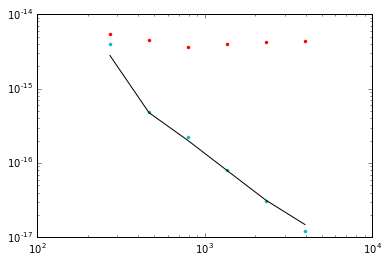

In [12]:
plt.loglog(lbins,pspec,'c.')
plt.loglog(lbins,pspec_m,'r.') 

plt.loglog(lbincenters,np.array(q).flatten()/np.diag(Fish)*(dtheta_rad**2)/(n**2)*n**4,'k-')

In [13]:
np.array(q).flatten()/np.diag(Fish)

array([  1.46712178e-12,   2.50189100e-13,   1.05754376e-13,
         4.18337345e-14,   1.66388200e-14,   7.83709643e-15])

In [14]:
inv(Fish)*q

matrix([[  1.46389621e-12],
        [  2.46939454e-13],
        [  1.02614020e-13],
        [  3.90066687e-14],
        [  1.47254947e-14],
        [  6.26147885e-15]])

In [15]:
inv(sqrtm(Fish))*q

matrix([[  1.16002182e-09],
        [  4.26039260e-10],
        [  5.25460196e-10],
        [  5.80492640e-10],
        [  6.43936838e-10],
        [  5.21389014e-10]])